In [1]:
# This notebook is the equivalent to read_and_xi.ipynb
# but it uses correlation measurements performed
# with Corrfunc.

In [2]:
from pathlib import Path # Handle paths more easily
import matplotlib.pyplot as plt # Make plots
import numpy as np 

import fitsio # Handle fits files
import sys # 
plt.style.use('tableau-colorblind10') # Change style to colorblind

In [3]:
# Import classes to read CoLoRe boxes and compute computations
# read abacus power spectra files in a similar way.
from CoLoRe_corrf_analysis.cf_helper import CFComputations, CFComputationsAbacus

In [4]:
rsd = False

# Read Model

In [5]:
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

In [6]:
# The model to fit for Pks (or correlations) takes as an input a CoLoRe box
# the model will be generated matching the cosmology of the given input box.
colore_box = Path("/pscratch/sd/c/cramirez/oxford_visit/test_boxes/colore_box_512_0_v0/results")

model = ComputeModelsCoLoRe(
    box_path=colore_box,
    source=2, # Important to also match the source for bias, etc...
    param_cfg_filename=colore_box.parent / "param.cfg", # Usually the code will try to find this file by reading the config, but it failis if it has been moved
    snapshot=True, # We are reading snapshots. This is only used to freeze bias evolution, etc...
    # smooth_factor=0, # For now we are going to ignore all smoothing factors
    # smooth_factor_rsd=0,
    # smooth_factor_cross=0,
    # smooth_factor_analysis=0,
    
)

# Ignore Failed reading bias and nz is using snapshot,
# bias can still be accessed
bias = model.bias(1)
# and nz is not needed here.

Failed reading bias from param.cfg
Failed reading nz from param.cfg


Text(0, 0.5, '$r^2 \\xi(r) \\, [Mpc^3 h^{-3}]$')

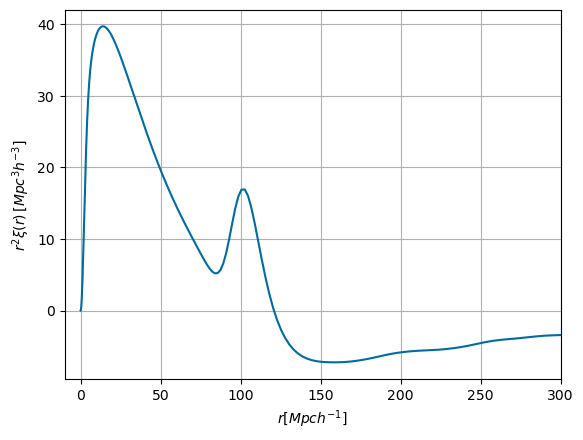

In [7]:
# Now a given model can be generated by using

xi = model.get_npole(0, z=2)

fig, ax = plt.subplots()

ax.plot(
    model.r,
    xi*model.r**2,
)
ax.grid()
ax.set_xlim(-10, 300)
ax.set_xlabel(r"$r [Mpc h^{-1}]$")
ax.set_ylabel(r"$r^2 \xi(r) \, [Mpc^3 h^{-3}]$")

## Read Abacus boxes 

In [8]:
# Path where PK output files are stored
abacus_output_location = Path(
    "/global/cfs/cdirs/desicollab/cosmosim/FirstGenMocks/AbacusSummit/Clustering/"
    "CubicBox/QSO/AbacusSummit_base_c000/z2.500/2PCF"
)

# Iterate over files and read the PK files. In this case we need to search these files.
# Whether we want to use rsd or not, we have different patterns
if rsd:
    pattern = "*RSD.dat"
else:
    pattern = "*REAL.dat"
    
# Create array to store the different power spectra
# one element per simulation
abacus_boxes = []

# Iterate over files, create instance per file
for pk_file in abacus_output_location.glob(pattern):
    abacus_boxes.append(CFComputationsAbacus(pk_file))

## Read Corrf outputs

Now we need to read Corrf output instead of directly CoLoRe.

In [9]:
x = CFComputations(
    Path("/pscratch/sd/c/cramirez/oxford_visit/test_boxes/colore_box_512_0_v0/Corrf/source_3rsd/results"))

In [13]:
# If we want to perform a similar analysis as with Abacus,
# we need to look at multiple CoLoRe boxes with the same
# cosmology.
corrf_outputs_glob = Path(
    "/pscratch/sd/c/cramirez/oxford_visit/test_boxes/"
).glob("*v0/Corrf/source_3rsd/results") # This will "search" all boxes finishing with v4, all of them are just variations with different seed

# Create array to store the different measurements
colore_boxes = []
for result in corrf_outputs_glob:
    # In the case of abacus, one file contains only one tracer
    # With CoLoRe we can read multiple tracers.
    colore_boxes.append(CFComputations(
        results_path=result,
    ))

## Make fits

In [14]:
from CoLoRe_corrf_analysis.fitter import Fitter

In [15]:
# A fitter takes as input both the boxes we want to use to read the data
# and the model we want to fit

colore_fit = Fitter(
    boxes=colore_boxes,
    z=2,
    poles=[0,], # Multipoles to include in the fit (we are fitting only monopole now since norsd
    theory=model, 
    rsd=rsd,
    rmin={0: 40}, # k-min and k-max in the fit are defined per multipole.
    rmax={0: 140},
)

# Let's define a similar fitter for Abacus
abacus_fit = Fitter(
    boxes=abacus_boxes,
    z=2,
    poles=[0,],
    theory=model,
    rsd=rsd,
    rmin={0: 40},
    rmax={0: 140},
)

In [16]:
# Now we can perform the actual fit. It can take a while if the data
# for the CoLoRe box has not been computed previously

# We pass the free parameters to the fitter.
# the parameters that can be set free in the fitter are:
    # "bias",
    # "smooth_factor",
    # "smooth_factor_rsd",
    # "smooth_factor_cross",
    # "bias2",
    # "scale_factor",
    # "z",

colore_fit.run_fit(["bias",]) 
# The fitter already outputs the results, but they can be accessed at any time
# by getting the attribute .out -> colore_fit.out

# colore_fit.out

In [17]:
# We can perform the same thing for Abacus
# just hidding the output by assigning it to a dummy variable
_ = abacus_fit.run_fit(["bias",])

In [18]:
from CoLoRe_corrf_analysis.plot_methods import Plots

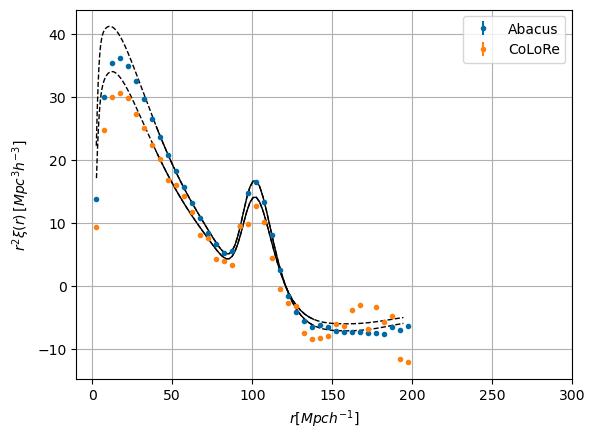

In [25]:
# Finally, we can plot the model with the data at the same time.

fig, ax = plt.subplots()

xis = np.array([box.compute_npole(n=0) for box in abacus_boxes])

ax.errorbar(
    abacus_boxes[0].savg, # r is the same for all of them, we can just pick the first one. savg means mean separation
    xis.mean(axis=0)*abacus_boxes[0].savg**2,
    yerr=xis.std(axis=0, ddof=1), #/len(abacus_boxes), If we divide by the number of boxes, we get the std of a single box.
    label="Abacus",
    fmt='.',
)

xis = np.array([box.compute_npole(n=0) for box in colore_boxes])

ax.errorbar(
    colore_boxes[0].savg, 
    xis.mean(axis=0)*colore_boxes[0].savg**2,
    yerr=xis.std(axis=0, ddof=1),
    label="CoLoRe",
    fmt='.',
)


##########################
### Adding the models
##########################
Plots.plot_best_fit(
    abacus_fit,
    pole=0, # Multipole we want to plot.
    ax=ax, # We pass the axis where we want to plot.
    plot_args=dict(c='k', lw=1)
)
    
Plots.plot_best_fit(
    colore_fit,
    pole=0, # Multipole we want to plot.
    ax=ax, # We pass the axis where we want to plot.
    plot_args=dict(c='k', lw=1)
)
    

ax.grid()
ax.set_xlim(-10, 300)
ax.set_xlabel(r"$r [Mpc h^{-1}]$")
ax.set_ylabel(r"$r^2 \xi(r) \, [Mpc^3 h^{-3}]$")
ax.legend()